In [451]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import stan
import torch
 
from scipy.sparse.linalg import svds
from scipy.spatial.distance import pdist, squareform
import auxiliary_stan as auxpl
figsize = auxpl.figsize
fontsize = auxpl.fontsize

In [452]:
sample_id = "V1_Human_Lymph_Node"
path = "results"
patch_size = 26
adata = sc.read("{}/{}{}*{}.h5ad".format(path, sample_id, patch_size, patch_size))
spot_names = adata.obs_names
adata

AnnData object with n_obs × n_vars = 3981 × 21261
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [453]:
adata_bigan = sc.read("{}/{}_stan_bigan.h5ad".format(path, sample_id))
adata_0 = sc.read("{}/{}_stan_o.h5ad".format(path, sample_id))
adata_ae = sc.read("{}/{}_stan_ae.h5ad".format(path, sample_id))
adata_dino = sc.read("{}/{}_stan_dino.h5ad".format(path, sample_id))
adata_ridge = sc.read("{}/{}_stan_ridge.h5ad".format(path, sample_id))

In [454]:
celltypes = pd.read_csv("data/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("data/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/3846279234.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gc_annotation = pd.read_csv("data/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)


In [455]:
def g_c(adata, celltypes, gc_annotation):
    obs_names = np.intersect1d(celltypes.index, adata.obs_names)
    adata = adata[obs_names]
    celltypes = celltypes.loc[obs_names]
    gc_annotation = gc_annotation.loc[obs_names]
    adata.obsm['celltype'] = celltypes
    adata.obsm['celltype'].columns =  [x.replace('mean_spot_factors','') for x in adata.obsm['celltype'].columns]
    adata.obsm['celltype_raw'] = adata.obsm['celltype'].copy()
    adata.obsm['celltype'] = adata.obsm['celltype'].divide(adata.obsm['celltype'].sum(axis=1), axis=0)
    adata.obs['germinal_center'] = gc_annotation
    adata.obs['germinal_center'] = adata.obs['germinal_center'].map({0: "Other", 1: "GC"})
    return adata
# output of STAN

In [456]:
adata = g_c(adata, celltypes, gc_annotation)
adata_bigan=g_c(adata_bigan, celltypes, gc_annotation)
adata_0=g_c(adata_0, celltypes, gc_annotation)
adata_ae=g_c(adata_ae, celltypes, gc_annotation)
adata_dino=g_c(adata_dino, celltypes, gc_annotation)
adata_ridge=g_c(adata_ridge, celltypes, gc_annotation)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: S

In [457]:
def n(adata):

    sc.pp.normalize_total(adata)
    adata.layers['scaled'] = np.sqrt(adata.to_df())
    
    sc.pp.normalize_total(adata)
    adata.layers['scaled'] = np.sqrt(adata.to_df())

n(adata_bigan)
n(adata_0)
n(adata_ae)
n(adata_dino)
n(adata_ridge)

In [458]:
adata_0.obsm['tfa_stan']

AHR        AR    ARID3A      ARNT     ARNTL  \
AAACAAGTATCTCCCA-1 -0.060852 -0.076435 -0.067346 -0.013018 -0.003774   
AAACAATCTACTAGCA-1 -0.061785 -0.081733 -0.079768 -0.024049  0.065126   
AAACACCAATAACTGC-1 -0.065141 -0.079508 -0.069584 -0.015049  0.001889   
AAACAGAGCGACTCCT-1 -0.072398 -0.068846 -0.075985 -0.015496  0.014667   
AAACAGCTTTCAGAAG-1 -0.078108 -0.092559 -0.081275 -0.023461  0.001122   
...                      ...       ...       ...       ...       ...   
TTGTTTCACATCCAGG-1 -0.073085 -0.079162 -0.081306 -0.015211  0.049218   
TTGTTTCATTAGTCTA-1 -0.063047 -0.069148 -0.070172 -0.017658  0.061134   
TTGTTTCCATACAACT-1 -0.067181 -0.080838 -0.071169 -0.020138  0.031763   
TTGTTTGTATTACACG-1 -0.064483 -0.077578 -0.077838 -0.020796  0.071542   
TTGTTTGTGTAAATTC-1 -0.060893 -0.073566 -0.072770 -0.014293  0.050018   

                       ASCL1     ASCL2      ATF1      ATF2      ATF3  ...  \
AAACAAGTATCTCCCA-1  0.014703 -0.026175  0.022006  0.088691 -0.034347  ...   
AAACAATCTACTAGCA-1 -0.004007 -0.021115  0.037440  0.086801 -0.042482  ...   
AAACACCAATAACTGC-1  0.009141 -0.021561  0.019054  0.085973 -0.026241  ...   
AAACAGAGCGACTCCT-1  0.002492 -0.016878  0.028395  0.079914 -0.024035  ...   
AAACAGCTTTCAGAAG-1  0.005920 -0.017749  0.041051  0.105098 -0.031681  ...   
...                      ...       ...       ...       ...       ...  ...   
TTGTTTCACATCCAGG-1  0.012324 -0.025529  0.026492  0.088556 -0.022544  ...   
TTGTTTCATTAGTCTA-1  0.000343 -0.014360  0.028496  0.089321 -0.034090  ...   
TTGTTTCCATACAACT-1 -0.000253 -0.026046  0.023543  0.091019 -0.029454  ...   
TTGTTTGTATTACACG-1  0.004434 -0.023585  0.033165  0.086811 -0.039180  ...   
TTGTTTGTGTAAATTC-1  0.007235 -0.028645  0.039458  0.092670 -0.031525  ...   

                      ZNF143    ZNF217    ZNF236    ZNF250    ZNF263  \
AAACAAGTATCTCCCA-1 -0.031362 -0.125473 -0.045410 -0.089712  0.011575   
AAACAATCTACTAGCA-1 -0.033503 -0.098563  0.042042 -0.125908 -0.011794   
AAACACCAATAACTGC-1 -0.026560 -0.096237 -0.018551 -0.153337  0.020694   
AAACAGAGCGACTCCT-1 -0.027695 -0.123112  0.002834 -0.169286 -0.000294   
AAACAGCTTTCAGAAG-1 -0.048122 -0.084401 -0.053834 -0.095471 -0.005216   
...                      ...       ...       ...       ...       ...   
TTGTTTCACATCCAGG-1 -0.041273 -0.105729  0.040482 -0.088349  0.005745   
TTGTTTCATTAGTCTA-1 -0.029545 -0.105125 -0.027795 -0.120566  0.006441   
TTGTTTCCATACAACT-1 -0.032279 -0.110501 -0.029634 -0.142860  0.005702   
TTGTTTGTATTACACG-1 -0.036782 -0.103689 -0.034883 -0.130609 -0.002348   
TTGTTTGTGTAAATTC-1 -0.046024 -0.176978  0.013961 -0.130921  0.005150   

                      ZNF281    ZNF384    ZNF711     ZNF76     ZNF84  
AAACAAGTATCTCCCA-1  0.030482  0.026943 -0.349115 -0.120657  0.174037  
AAACAATCTACTAGCA-1  0.134861  0.031414 -0.434459 -0.157389  0.156097  
AAACACCAATAACTGC-1  0.097385  0.029908 -0.355634 -0.115529  0.127983  
AAACAGAGCGACTCCT-1  0.120835  0.017494 -0.305534 -0.150644  0.036250  
AAACAGCTTTCAGAAG-1  0.058872  0.027143 -0.317498 -0.134175  0.207994  
...                      ...       ...       ...       ...       ...  
TTGTTTCACATCCAGG-1  0.074530  0.028514 -0.300130 -0.128483  0.146361  
TTGTTTCATTAGTCTA-1  0.072210  0.027150 -0.388893 -0.134682  0.092379  
TTGTTTCCATACAACT-1  0.085964  0.023236 -0.346214 -0.127256  0.119283  
TTGTTTGTATTACACG-1  0.061589  0.018522 -0.370765 -0.143236  0.095513  
TTGTTTGTGTAAATTC-1  0.037673  0.033259 -0.342182 -0.138082  0.098957  

[3979 rows x 234 columns]

In [459]:
adata_0

AnnData object with n_obs × n_vars = 3979 × 8926
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'pixel', 'pred_cor_stan_AE', 'pred_cor_stan_BIGAN', 'pred_cor_stan_dino', 'pred_cor_stan_origin', 'germinal_center'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'fold', 'pred_cor_stan_AE', 'pred_cor_stan_BIGAN', 'pred_cor_stan_dino', 'pred_cor_stan_origin'
    uns: 'spatial', 'tf_names'
    obsm: 'kernel', 'pixel', 'spatial', 'tfa_stan', 'celltype', 'celltype_raw'
    varm: 'gene_tf'
    layers: 'raw', 'scaled'
    obsp: 'kernel', 'pw_dist'

In [460]:
#把adata原数值替换为.obsm['tfa_stan']
adata_tfa_0 = adata_0.copy()
adata_tfa_bigan = adata_bigan.copy()
adata_tfa_ae = adata_ae.copy()
adata_tfa_dino = adata_dino.copy()
adata_tfa_ridge = adata_ridge.copy()


In [461]:
import pandas as pd
import anndata

def get_activation(adata):
    # 提取 'tfa_stan' 矩阵
    tfa_stan = adata.obsm['tfa_stan']
    
    # 创建新的变量名称
    var_names = [f'tfa_stan_{i}' for i in range(tfa_stan.shape[1])]
    
    # 创建新的 var DataFrame
    new_var = pd.DataFrame(index=var_names)
    
    # 创建新的 AnnData 对象
    adata_tfa = anndata.AnnData(
        X=tfa_stan.copy()
    )
    
    return adata_tfa

# 使用函数创建新的 AnnData 对象
adata_tfa_0 = get_activation(adata_0)


In [462]:
adata_tfa_0
adata_tfa_0=g_c(adata_tfa_0, celltypes, gc_annotation)
adata_tfa_bigan = get_activation(adata_bigan)
adata_tfa_bigan=g_c(adata_tfa_bigan, celltypes, gc_annotation)
adata_tfa_ae = get_activation(adata_ae)
adata_tfa_ae=g_c(adata_tfa_ae, celltypes, gc_annotation)
adata_tfa_dino = get_activation(adata_dino)
adata_tfa_dino=g_c(adata_tfa_dino, celltypes, gc_annotation)
adata_tfa_ridge = get_activation(adata_ridge)
adata_tfa_ridge=g_c(adata_tfa_ridge, celltypes, gc_annotation)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  adata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_43976/1977107635.py:6: ImplicitModificationWarning: S

In [463]:
adata_tfa_bigan

AnnData object with n_obs × n_vars = 3979 × 234
    obs: 'germinal_center'
    obsm: 'celltype', 'celltype_raw'

In [464]:
df_celltype = auxpl.merge_celltypes(adata)



df_celltype = df_celltype.loc[adata.obs_names, :]

adata.obsm['celltype_major'] = df_celltype
adata_bigan.obsm['celltype_major'] = df_celltype
adata_tfa_0.obsm['celltype_major'] = df_celltype
adata_tfa_bigan.obsm['celltype_major'] = df_celltype  
adata_tfa_ae.obsm['celltype_major'] = df_celltype
adata_tfa_dino.obsm['celltype_major'] = df_celltype
adata_tfa_ridge.obsm['celltype_major'] = df_celltype

mat_cor_tfa_stan, mat_cor_rna = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_0, celltype_label='celltype_major')
mat_cor_tfa_bigan, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_bigan, celltype_label='celltype_major')
mat_cor_tfa_ae, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_ae, celltype_label='celltype_major')
mat_cor_tfa_dino, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_dino, celltype_label='celltype_major')
mat_cor_tfa_ridge, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_ridge, celltype_label='celltype_major')



In [465]:

import squidpy as sq
def plot_spatial_ct_tf(ct, tf):
    fig, axs = plt.subplots(2,3, figsize=(figsize*5,figsize*2), dpi=200)
    # sc.pl.spatial(sq.pl.extract(adata_filtered, "celltype_major"),
    #               color=ct, alpha_img=0, ax=axs[0,0], show=False, cmap="rocket", size=1.8,
    #               legend_fontsize=fontsize)
    sc.pl.spatial(adata, color=tf, alpha_img=0, ax=axs[0,0],show=False, cmap="rocket", legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_tfa_0, color=tf, alpha_img=0, ax=axs[0,1],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)

    sc.pl.spatial(adata_tfa_bigan, color=tf, alpha_img=0, ax=axs[0,2],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_ae, color=tf, alpha_img=0, ax=axs[1,0],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_dino, color=tf, alpha_img=0, ax=axs[1,1],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_ridge, color=tf, alpha_img=0, ax=axs[1,2],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    
    
    
    axs[0,0].set_title(tf+" mRNA expr\nPearson r =%.4f"% mat_cor_rna.loc[tf, ct], fontsize=fontsize)
    axs[0,1].set_title(tf+" activity (STAN)\nPearson r =%.4f"% mat_cor_tfa_stan.loc[tf, ct], fontsize=fontsize)
    axs[0,2].set_title(tf+' activity (bigan)\nPearson r =%.4f'% mat_cor_tfa_bigan.loc[tf, ct], fontsize=fontsize)
    axs[1,0].set_title(tf+' activity (ae)\nPearson r =%.4f'% mat_cor_tfa_ae.loc[tf, ct], fontsize=fontsize)
    axs[1,1].set_title(tf+' activity (dino)\nPearson r =%.4f'% mat_cor_tfa_dino.loc[tf, ct], fontsize=fontsize)
    axs[1,2].set_title(tf+' activity (ridge)\nPearson r =%.4f'% mat_cor_tfa_ridge.loc[tf, ct], fontsize=fontsize)
 

In [466]:
adata_tfa_0.uns['spatial'] = adata.uns['spatial']
adata_tfa_bigan.uns['spatial'] = adata.uns['spatial']
adata_tfa_0.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_bigan.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_ae.uns['spatial'] = adata.uns['spatial']
adata_tfa_ae.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_dino.uns['spatial'] = adata.uns['spatial']
adata_tfa_dino.obsm['spatial'] = adata.obsm['spatial']
adata_tfa_ridge.uns['spatial'] = adata.uns['spatial']
adata_tfa_ridge.obsm['spatial'] = adata.obsm['spatial']

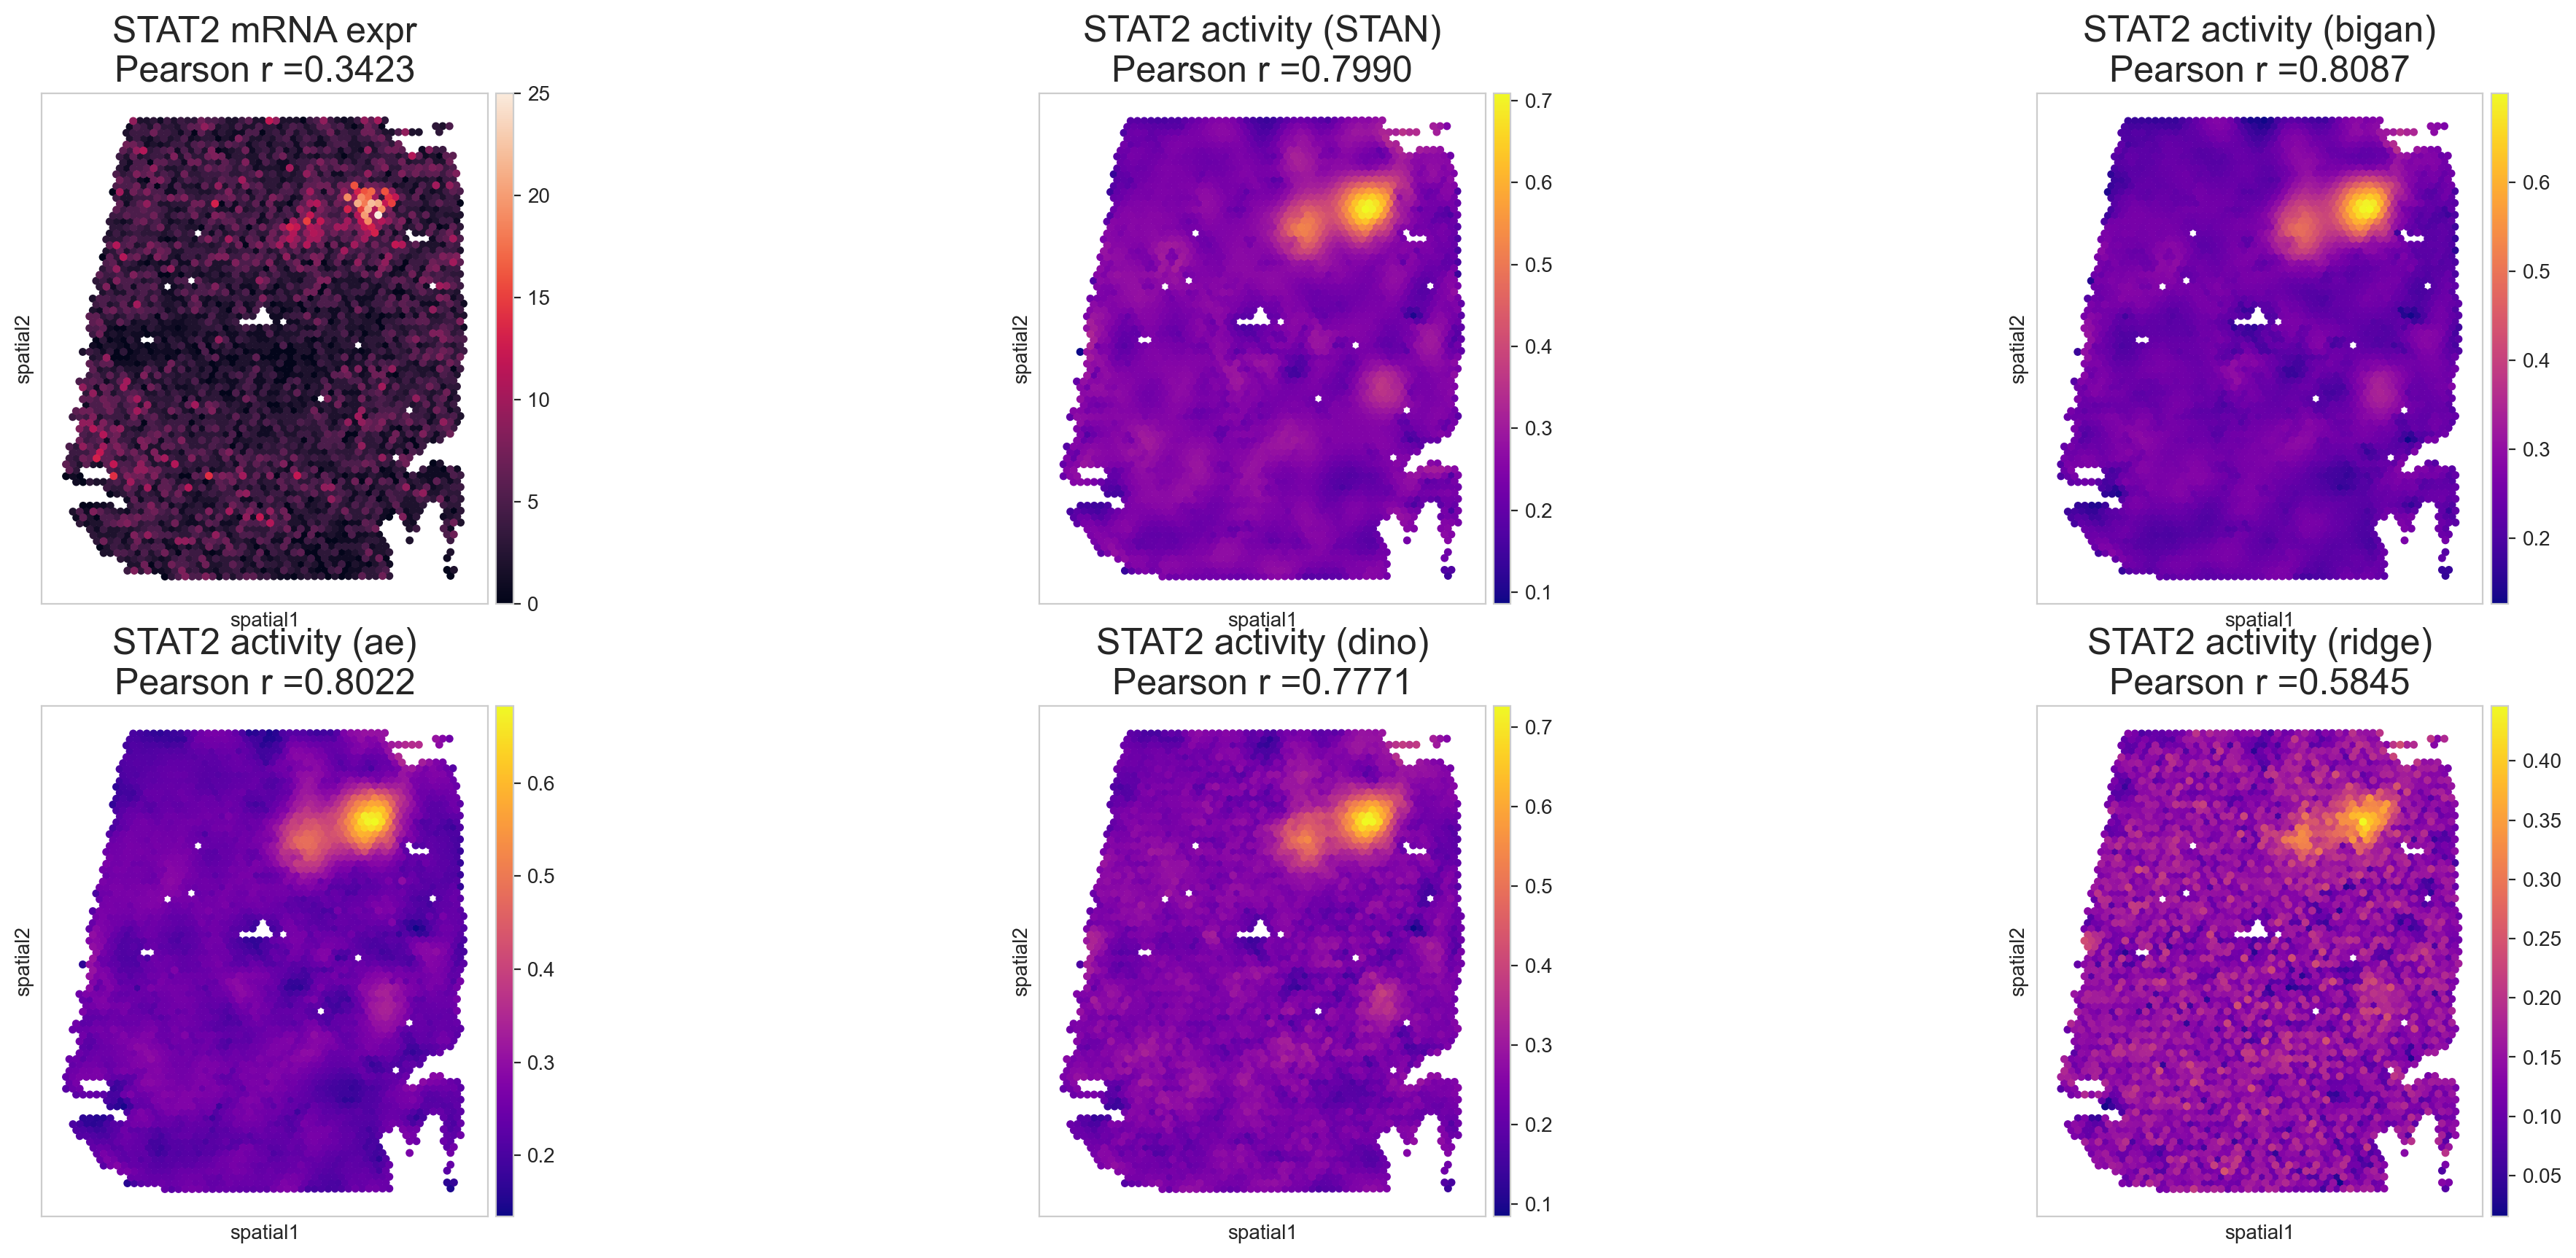

In [467]:
plot_spatial_ct_tf(ct = "B_IFN", tf = "STAT2")

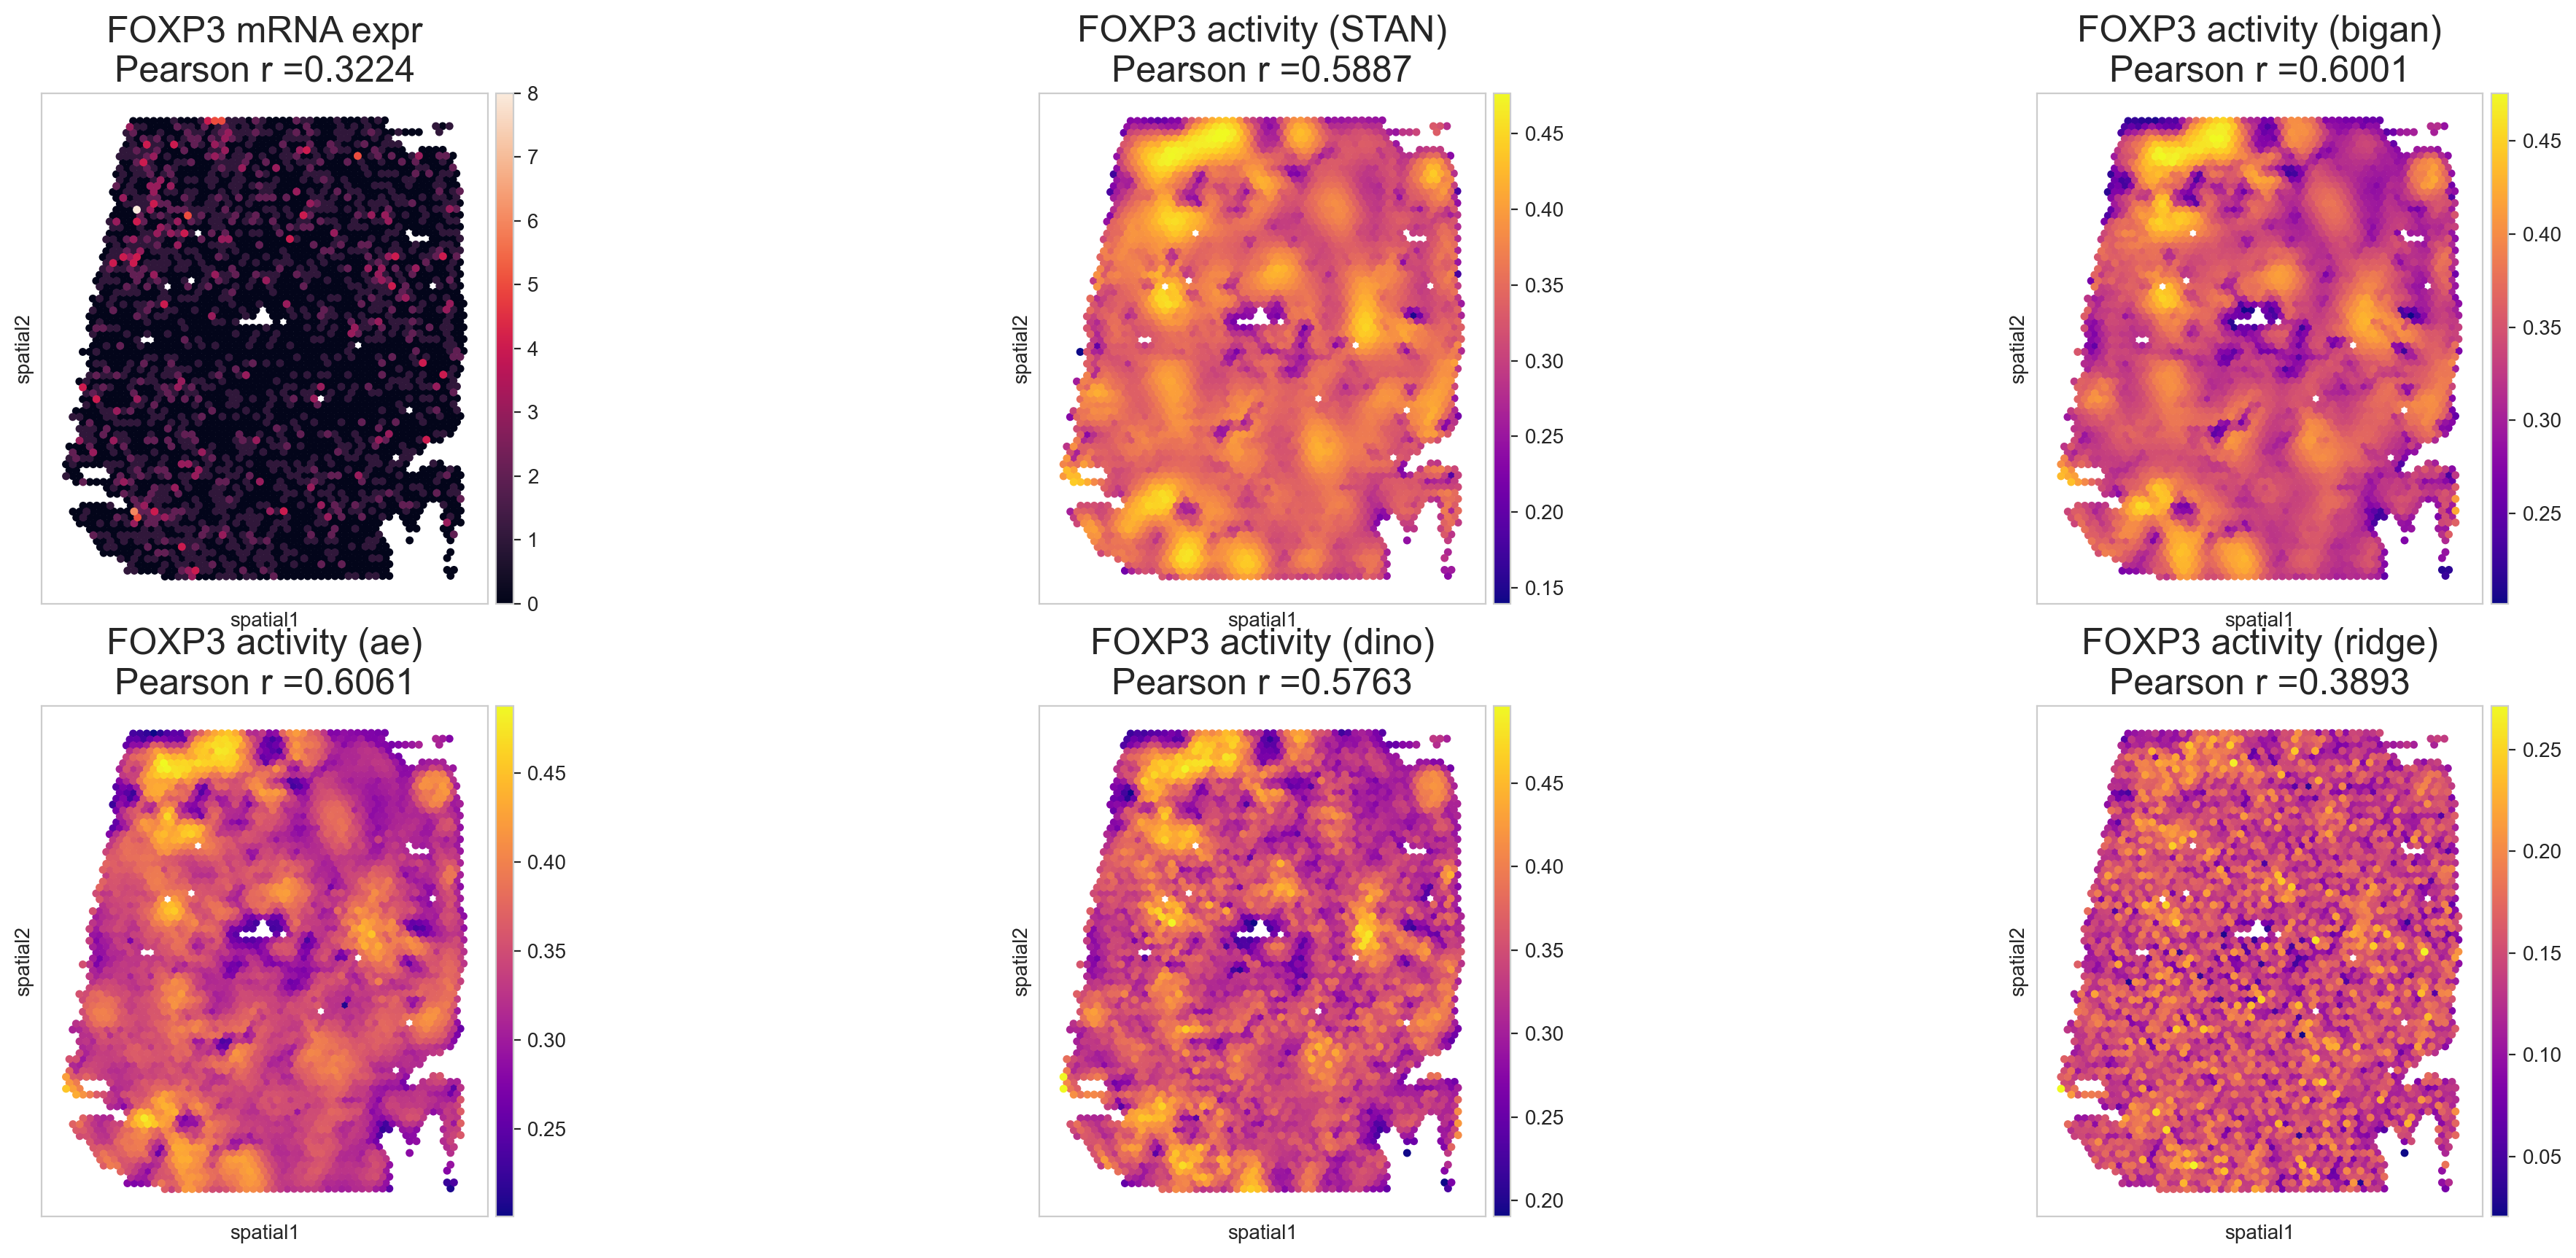

In [468]:
plot_spatial_ct_tf(ct = "T_Treg", tf = "FOXP3")